In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import glob
import matplotlib.pyplot as plt
import imutils
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA, KernelPCA
from sklearn.ensemble import RandomForestClassifier

In [ ]:
ext = ['jpg', 'JPG', 'pnp', 'jpeg']


def get_files(path_, ext):
    temp_paths = []
    [temp_paths.extend(glob.glob(path_ + '*.' + e)) for e in ext]
    return temp_paths

files_yes = get_files('/content/drive/MyDrive/yes/', ext)
files_no = get_files('/content/drive/MyDrive/no/', ext)





In [ ]:
def read_files(files):
    temp_images = []
    for file in files:
        temp_img = cv2.imread(file)
        if temp_img is not None:
            temp_images.append(temp_img)  
    return temp_images


tumor_imgs_yes = read_files(files_yes)
tumor_imgs_no = read_files(files_no)

In [ ]:
len(tumor_imgs_yes)


150

In [ ]:

def crop_brain(image):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            
    
    return new_image




In [ ]:
tumor_imgs_croped_yes = []
tumor_imgs_croped_no = []



for image in tumor_imgs_yes:
    x = crop_brain(image)
    x_resize = cv2.resize(x, (128, 128))
    gray = cv2.cvtColor(x_resize, cv2.COLOR_BGR2GRAY)
    tumor_imgs_croped_yes.append(gray)


for image in tumor_imgs_no:
    x = crop_brain(image)

    x_resize = cv2.resize(x, (128, 128))
    gray = cv2.cvtColor(x_resize, cv2.COLOR_BGR2GRAY)
    tumor_imgs_croped_no.append(gray)


y_yes = np.ones(len(tumor_imgs_croped_yes), dtype="int8")
y_no = np.zeros(len(tumor_imgs_croped_no), dtype="int8")


X = np.concatenate((tumor_imgs_croped_yes, tumor_imgs_croped_no), axis=0)
y = np.concatenate((y_yes, y_no), axis=0)

d1, d2, d3 = X.shape


In [ ]:
tumor_imgs_nocroped_yes = []
tumor_imgs_nocroped_no = []


for x in tumor_imgs_yes:
    x_resize = cv2.resize(x, (128, 128))
    gray = cv2.cvtColor(x_resize, cv2.COLOR_BGR2GRAY)
    tumor_imgs_nocroped_yes.append(gray)


for x in tumor_imgs_no:
    x_resize = cv2.resize(x, (128, 128))
    gray = cv2.cvtColor(x_resize, cv2.COLOR_BGR2GRAY)
    tumor_imgs_nocroped_no.append(gray)


y_nocrop_yes = np.ones(len(tumor_imgs_nocroped_yes), dtype="int8")
y_nocrop_no = np.zeros(len(tumor_imgs_nocroped_no), dtype="int8")


nocrop_X = np.concatenate((tumor_imgs_nocroped_yes, tumor_imgs_nocroped_no), axis=0)
nocrop_y = np.concatenate((y_nocrop_yes, y_nocrop_no), axis=0)

d1, d2, d3 = nocrop_X.shape

In [ ]:
X.shape

(245, 128, 128)

In [ ]:
nocrop_X.shape

(245, 128, 128)

In [ ]:
X = X.reshape((d1, d2 * d3))
X.shape

(245, 16384)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

In [ ]:
nocrop_X_train, nocrop_X_test, nocrop_y_train, nocrop_y_test = train_test_split(nocrop_X, nocrop_y, test_size=0.1, random_state=5)

In [ ]:
X_train.shape

(220, 128, 128)

In [ ]:
nocrop_X_train.shape

(220, 128, 128)

In [ ]:
# scale data before train model
scaler_ = StandardScaler()
X_train_sc = scaler_.fit_transform(X_train)
X_test_sc = scaler_.transform(X_test)


# random forest without pca
rf_model = RandomForestClassifier()
rf_model.fit(X_train_sc, y_train)
y_predict_rf = rf_model.predict(X_test_sc)


# SVC without pca
svc_model = SVC(kernel="linear")
svc_model.fit(X_train_sc, y_train)
y_predict_svc = svc_model.predict(X_test_sc)

# PCA
data_pca = PCA(n_components=12)
pca_components = data_pca.fit(X_train_sc)
X_train_pca = pca_components.fit_transform(X_train_sc)
X_test_pca = pca_components.transform(X_test_sc)

# KernelPCA
data_kpca = KernelPCA()
kpca_components = data_kpca.fit(X_train_sc)
X_train_kpca = kpca_components.fit_transform(X_train_sc)
X_test_kpca = kpca_components.transform(X_test_sc)


# RandomForest With PCA
rf_model_pca = RandomForestClassifier()
rf_model_pca.fit(X_train_pca, y_train)
y_predict_rf_pca = rf_model_pca.predict(X_test_pca)

# SVC With PCA
svc_model_pca = SVC(kernel="linear")
svc_model.fit(X_train_pca, y_train)
y_predict_pca = svc_model.predict(X_test_pca)


# RandomForest With KernelPCA
rf_model_kpca = RandomForestClassifier()
rf_model_kpca.fit(X_train_kpca, y_train)
y_predict_rf_kpca = rf_model_kpca.predict(X_test_kpca)

# SVC With KernelPCA
svc_model_kpca = SVC(kernel="linear")
svc_model.fit(X_train_kpca, y_train)
y_predict_kpca = svc_model.predict(X_test_kpca)


print("SVC without PCA: ", accuracy_score(y_test, y_predict_svc))
print("SVC with PCA: ", accuracy_score(y_test, y_predict_pca))

print("SVC without PCA:")
print(classification_report(y_test, y_predict_svc))
print("SVC with PCA:")
print(classification_report(y_test, y_predict_pca))


print("RandomForest without PCA:")
print(classification_report(y_test, y_predict_rf))

print("RandomForest with PCA:")
print(classification_report(y_test, y_predict_rf_pca))


print("RandomForest without KPCA:")
print(classification_report(y_test, y_predict_rf_kpca))

print("SVC with KPCA:")
print(classification_report(y_test, y_predict_kpca))

SVC without PCA:  0.6
SVC with PCA:  0.52
SVC without PCA:
              precision    recall  f1-score   support

           0       0.44      0.44      0.44         9
           1       0.69      0.69      0.69        16

    accuracy                           0.60        25
   macro avg       0.57      0.57      0.57        25
weighted avg       0.60      0.60      0.60        25

SVC with PCA:
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         9
           1       0.62      0.62      0.62        16

    accuracy                           0.52        25
   macro avg       0.48      0.48      0.48        25
weighted avg       0.52      0.52      0.52        25

RandomForest without PCA:
              precision    recall  f1-score   support

           0       0.80      0.44      0.57         9
           1       0.75      0.94      0.83        16

    accuracy                           0.76        25
   macro avg       0.78      

In [ ]:
"""
CNN with crop image 
"""

In [ ]:
import tensorflow
from tensorflow import keras
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=32, input_shape=[128, 128, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=100, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=1, activation='sigmoid'),])

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20,batch_size=50,validation_split=0.15)

Epoch 1/20
4/4 [==============================] - 7s 2s/step - loss: 40.3821 - accuracy: 0.5668 - val_loss: 2.2883 - val_accuracy: 0.5152
Epoch 2/20
4/4 [==============================] - 6s 1s/step - loss: 7.2207 - accuracy: 0.4492 - val_loss: 0.9313 - val_accuracy: 0.6970
Epoch 3/20
4/4 [==============================] - 6s 1s/step - loss: 1.0616 - accuracy: 0.6096 - val_loss: 0.5289 - val_accuracy: 0.6970
Epoch 4/20
4/4 [==============================] - 6s 1s/step - loss: 0.6274 - accuracy: 0.6738 - val_loss: 0.5785 - val_accuracy: 0.7576
Epoch 5/20
4/4 [==============================] - 6s 1s/step - loss: 0.6187 - accuracy: 0.7112 - val_loss: 0.6043 - val_accuracy: 0.6970
Epoch 6/20
4/4 [==============================] - 6s 1s/step - loss: 0.5887 - accuracy: 0.7487 - val_loss: 0.5602 - val_accuracy: 0.6364
Epoch 7/20
4/4 [==============================] - 6s 1s/step - loss: 0.5164 - accuracy: 0.7433 - val_loss: 0.5825 - val_accuracy: 0.6970
Epoch 8/20
4/4 [========================

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 128)     

In [ ]:
model.evaluate(X_test,y_test)

1/1 [==============================] - 0s 225ms/step - loss: 0.9875 - accuracy: 0.7200


[0.9875375628471375, 0.7200000286102295]

In [ ]:

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_accuracy(history, label, n):
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['accuracy'],  color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_accuracy'], color=colors[n], label='Val '+label, 
                       linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
  
    plt.legend()



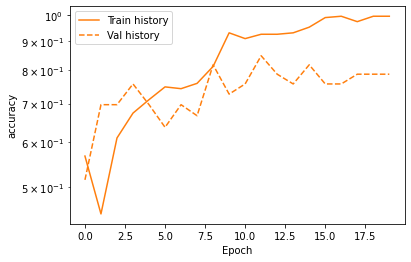

In [ ]:
plot_accuracy(history, "history", 1)

In [ ]:
"""
result:
72% accuracy on test data set with croped images
"""

In [ ]:
"""
CNN with out crop :
"""

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history_no2 = model.fit(nocrop_X_train, nocrop_y_train,batch_size=50, epochs=20,validation_split=0.15)

Epoch 1/20
4/4 [==============================] - 8s 2s/step - loss: 0.5282 - accuracy: 0.7914 - val_loss: 0.4388 - val_accuracy: 0.8788
Epoch 2/20
4/4 [==============================] - 6s 1s/step - loss: 0.3742 - accuracy: 0.8396 - val_loss: 0.3633 - val_accuracy: 0.8788
Epoch 3/20
4/4 [==============================] - 6s 1s/step - loss: 0.3228 - accuracy: 0.8610 - val_loss: 0.5481 - val_accuracy: 0.8182
Epoch 4/20
4/4 [==============================] - 6s 1s/step - loss: 0.2978 - accuracy: 0.8877 - val_loss: 0.5468 - val_accuracy: 0.7273
Epoch 5/20
4/4 [==============================] - 6s 1s/step - loss: 0.2483 - accuracy: 0.9037 - val_loss: 0.5284 - val_accuracy: 0.8485
Epoch 6/20
4/4 [==============================] - 6s 1s/step - loss: 0.2020 - accuracy: 0.9091 - val_loss: 0.9037 - val_accuracy: 0.6970
Epoch 7/20
4/4 [==============================] - 8s 2s/step - loss: 0.2009 - accuracy: 0.9305 - val_loss: 0.5740 - val_accuracy: 0.9091
Epoch 8/20
4/4 [=========================